<center><h2>ALTeGraD 2023<br>Lab Session 3: Transfer learning for NLP</h2> 24 / 10 / 2023<br> Dr. G. Shang, H. Abdine<br><br>


<b>Student name:</b> [Maïssane MERRHEIM]

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>

<b>The deadline for this lab is October 31, 2023 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [49]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [50]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value

        d_model (int) – the number of expected features in the input (required).
        nhead (int) – the number of heads in the multiheadattention models (required).
        dim_feedforward (int) – the dimension of the feedforward network model (default=2048).
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntoken,nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid,dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid,nhead,nhid,dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid)
        src = self.pos_encoder(src) #fill me
        output = self.transformer_encoder(src,src_mask) #fill me
        return output

class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid,nclasses) #fill me)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output

class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout=0.5) #fill me
        self.classifier = ClassificationHead(nhid, nclasses) #fill me

    def forward(self, src, src_mask):
        # base model
        x = self.base(src,src_mask) #fill me
        # classifier model
        output = self.classifier(x) #fill me
        return output

In [51]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [52]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)

out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [53]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2023-10-31 16:27:21--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt.1’

dict.txt.1          100%[===================>] 564.05K  --.-KB/s    in 0.05s   

2023-10-31 16:27:21 (11.5 MB/s) - ‘dict.txt.1’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [54]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] = (idx + 4)  #fill me

ind2token = {idx: word for word, idx in token2ind.items()} #fill me
print(ind2token[1111])

▁trop


### Data Loader


In [55]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        # token2ind.get to get the ind of the token. If the token is not in token2ind, replace with <oov>.
        source_sequence = [self.token2ind.get(token, self.token2ind["<oov>"]) for token in sequence]
        # add the special tokens sos and eos
        source_sequence = [self.token2ind["<sos>"]] + source_sequence + [self.token2ind["<eos>"]]
        #fill me (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [56]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )

    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1] #fill me # we take the last vector only
        output = output.view(-1, output.shape[-1])
        target = data[1].to(device) #fill me
        target = target.to(device)

        # We compute the loss function (between the target and the ouput)
        loss = criterion(output, target)  #fill me step 3 #criterion = nn.CrossEntropyLoss()
        optimizer.zero_grad()
        loss.backward() #backpropagation


        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient


        #fill me step 4
        optimizer.step()

        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [57]:
print(len(token2ind))

50001


In [58]:
ntokens = len(token2ind) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [59]:
# optimization parameters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [60]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2023-10-31 16:27:22--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt.1’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2023-10-31 16:27:22 (95.0 MB/s) - ‘pretraining_subset.txt.1’ saved [10146460/10146460]



In [61]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task='language_modeling', # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.49216 | ppl 1793.929
| epoch   1 |  1000/ 3125 steps | loss 6.79344 | ppl  891.977
| epoch   1 |  1500/ 3125 steps | loss 6.57226 | ppl  714.982
| epoch   1 |  2000/ 3125 steps | loss 6.40342 | ppl  603.908
| epoch   1 |  2500/ 3125 steps | loss 6.27381 | ppl  530.493
| epoch   1 |  3000/ 3125 steps | loss 6.16375 | ppl  475.206
| epoch   2 |   500/ 3125 steps | loss 5.98313 | ppl  396.679
| epoch   2 |  1000/ 3125 steps | loss 5.90859 | ppl  368.188
| epoch   2 |  1500/ 3125 steps | loss 5.85254 | ppl  348.118
| epoch   2 |  2000/ 3125 steps | loss 5.82886 | ppl  339.972
| epoch   2 |  2500/ 3125 steps | loss 5.80210 | ppl  330.992
| epoch   2 |  3000/ 3125 steps | loss 5.75742 | ppl  316.531


## Text Generation


In [62]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt')
#load state dict
model.load_state_dict(checkpoint['model_state_dict'])

--2023-10-31 16:32:12--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt.1’

pretrained_model_4l 100%[===================>]  84.01M   261MB/s    in 0.3s    

2023-10-31 16:32:12 (261 MB/s) - ‘pretrained_model_4layers.pt.1’ saved [88093955/88093955]



<All keys matched successfully>

In [63]:
# !pip install sentencepiece   # uncomment this if you are using google colab
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
!pip install sentencepiece
import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

--2023-10-31 16:32:13--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model.1’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-31 16:32:13 (17.9 MB/s) - ‘sentencepiece.french.model.1’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [64]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    sent_pieces = [item for sublist in sent_pieces for item in sublist]
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = torch.argmax(out, dim=2)[-1].item() #fill me
    return next_token_ind, out

def infer_next_tokens(sent, max_len=50):
    input_sentence = s.encode_as_pieces(sent) #input_sentence est donc maintenant une liste ['_Bonjour','_les']
    ind_next_token = 0
    while len(input_sentence) < max_len: #because we have to take into account the lenght of the first words in the input sentence
      ind_next_token = infer_next_token(input_sentence)[0]
      input_sentence.append(ind2token[ind_next_token]) #add to the list (encoded input sentence) the predicted tokens
      if ind_next_token == 2: #2 corresponds to <eos>
        break #return the decoded input_sentence
    return s.decode_pieces(input_sentence) #return the decoded input_sentence

In [65]:
sent = "Bonjour les"
infer_next_tokens(sent,50)

'Bonjour les gens qui ont été très accueillants et sympathiques.<eos>'

### Supervised task

In [66]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2023-10-31 16:32:17--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm.2’

train.review.spm.2  100%[===================>]   1.43M  --.-KB/s    in 0.06s   

2023-10-31 16:32:17 (23.0 MB/s) - ‘train.review.spm.2’ saved [1495960/1495960]

--2023-10-31 16:32:17--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request s

In [67]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
  #to be implemented
  model.eval()
  total_correct = 0
  total_instances = 0

  with torch.no_grad():
    for data in data_loader:
      input, label = data
      input = input.to(device)
      label = label.to(device)

      predictions = model(input, model.base.generate_square_subsequent_mask(input.size(0)).to(device))[-1]

      classes = torch.argmax(predictions, dim=-1)
      label = label.view(-1)

      correct = (classes == label).sum().item()
      total_correct += correct
      total_instances += label.size(0)

  accuracy = (total_correct / total_instances) * 100

  return accuracy

In [68]:
print(model)

Model(
  (base): TransformerModel(
    (encoder): Embedding(50001, 200)
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
          )
          (linear1): Linear(in_features=200, out_features=200, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=200, out_features=200, bias=True)
          (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
    )
  )
  (classifier): ClassificationHead(
    (decoder): Linear(in_features=200, out_feat

In [69]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [71]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.81034 | ppl    2.249
| epoch   1 |   100/  200 steps | loss 0.74250 | ppl    2.101
| epoch   1 |   150/  200 steps | loss 0.75828 | ppl    2.135
| epoch   2 |    50/  200 steps | loss 0.76630 | ppl    2.152
| epoch   2 |   100/  200 steps | loss 0.76499 | ppl    2.149
| epoch   2 |   150/  200 steps | loss 0.73869 | ppl    2.093
| epoch   3 |    50/  200 steps | loss 0.76610 | ppl    2.151
| epoch   3 |   100/  200 steps | loss 0.73364 | ppl    2.083
| epoch   3 |   150/  200 steps | loss 0.70753 | ppl    2.029
| epoch   4 |    50/  200 steps | loss 0.66960 | ppl    1.953
| epoch   4 |   100/  200 steps | loss 0.62744 | ppl    1.873
| epoch   4 |   150/  200 steps | loss 0.66390 | ppl    1.942
| epoch   5 |    50/  200 steps | loss 0.54388 | ppl    1.723
| epoch   5 |   100/  200 steps | loss 0.52122 | ppl    1.684
| epoch   5 |   150/  200 steps | loss 0.49975 | ppl    1.648
| epoch   6 |    50/  200 steps | loss

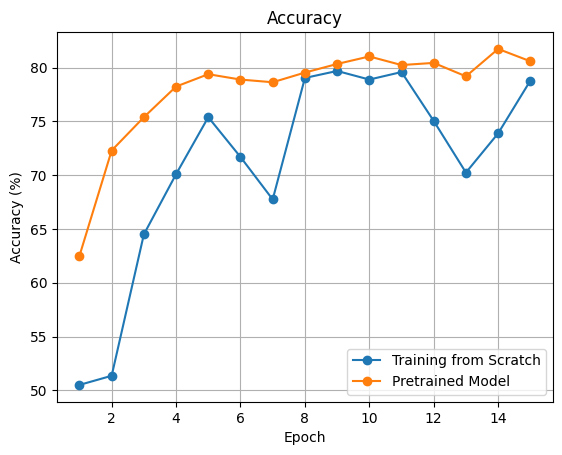

In [73]:
#Visualize the accuracy

import matplotlib.pyplot as plt
epochs = list(range(1, 16))

plt.plot(epochs, from_scratch_valid_acc, label='Training from Scratch', marker='o')
plt.plot(epochs, pretrained_valid_acc, label='Pretrained Model', marker='o')

# Configurez le titre et les légendes
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Affichez le graphique
plt.grid(True)
plt.show()
